## Step 1
Imports and initialisation of a LJ calculator

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ase
from ase.visualize import view
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones

lj_calc = LennardJones(sigma=1.0, epsilon=1.0, rc=12.0)

## Step 2
Initialisation of the simulation box.
Parameters:
- 19 LJ atoms
- Side length = 12

### Box side length
12 Å seems to work with no issues, sufficiently large to house all of the atoms.

### Initial positions
When randomised across the entire box space, particles are so spaced out that instead of forming one 19-atom cluster, they form mini-clusters typically containing 2 - 6 atoms. ![test_minimisation](./images/test_min.png)


This is because the atoms are so far apart, the force between particles is negligible, and so they will rarely converge to form a single cluster. 

So instead of randomising the particles across the entire simulation box, I have restricted the random distribution to a theoretical box occupying the centre of the simuation box that is half the size.

In [ ]:
def initialise_structure(n, box_length):
    '''
    n: int, number of atoms to place in the simulation box
    box_length: int/float, box side length in Å
    '''

    cell = np.eye(3)*box_length # 3x3 matrix with box_length across the diagonal
    atoms = ase.Atoms(pbc=True, cell = cell) #Atoms object which creates simulation box and contain all atoms
    for i in range(n):
        #pos = np.random.rand(3)*cell[1,1] ## randomising positions across the entire simulation box -- doesn't yield desired cluster as discussed in the above markdown cell
        pos = np.random.uniform(box_length*0.25, box_length*0.75, size = 3) # generates random coordinates restricted to the center of the simulation box 
        atoms.append(ase.Atom('He', position = pos)) #add atom to Atoms object

    return atoms

In [ ]:
n = 19 # number of LJ atoms
box_length = 12 # box side length

lj_19 = initialise_structure(19, 12)
view(lj_19, viewer='x3d')

## Step 3

Test minimisation to determine parameters `fmax` and `steps` for an appropriate level of convergence.

Through various trials, the energy value (given to 6 decimal places here) doesn't fluctuate much (or at all) below `fmax = 0.001`, thus this seems a reasonable cutoff for a minima such that computation isn't "wasted".

`steps = 1024` seems more than sufficient for the test system. After repeated tests it seems that the system rarely requires above 500 steps to minimise. Indeed, one could limit steps to ~ 600-700, as those that require more than ~ 700 steps likely wont minimise before 1024, though I have seen some cases where they do, so 1024 seems a reasonable buffer.

In [8]:
def minimise_structure(atoms, f_max=0.001, steps = 1024, id = "test"):
    '''
    atoms: Atoms object, contains structure for minimisation
    f_max: float, atomic force threshold below which structure is sufficiently minimised 
    steps: int, maximum number of minimisation steps before exiting minimisation
    '''

    atoms.calc = lj_calc #assigning LJ calculator to Atoms object
    dyn = BFGS(atoms=atoms, trajectory=f'./trajectories/{atoms.symbols}_{id}.traj') # set up BFGS minimiser for the Atoms object
    return dyn.run(fmax=f_max,steps=steps) # perform minimisation

minimise_structure(lj_19)

      Step     Time          Energy          fmax
BFGS:    0 19:58:00      -67.109115        0.000632


np.True_

In [7]:
view(lj_19, viewer='x3d')

## Step 4

Performing 100 minimisation cycles starting from a randomised inital structure each time. Generates a database of minim

In [13]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

energies = [] #array to store all of the minimised energies as they are generated
structures = [] #array to store all the final Atoms objects after minimisation

failed = []

'''
for 100 iterations, initialise a simulation box, conduct an energy minimisation,
then store the results in the `energies` and `structures` arrays. If failed, append
index of the failed simulation to the `failed` array for inspection.
'''
for i in range(100):

    lj_19 = initialise_structure(n = n, box_length = box_length)
    minimisation = minimise_structure(lj_19, id = i)

    energy = lj_19.get_potential_energy()
    energies.append(energy)
    structures.append(lj_19)

    if not minimisation:
        failed.append(i)

      Step     Time          Energy          fmax
BFGS:    0 20:00:02      544.583345    10454.977272
BFGS:    1 20:00:02       -5.770123        6.922286
BFGS:    2 20:00:02       -6.122764        6.885276
BFGS:    3 20:00:02       -6.620798        6.821770
BFGS:    4 20:00:02       -3.793555       43.266185
BFGS:    5 20:00:02       -7.272698        6.726563
BFGS:    6 20:00:02       -7.907924        6.627711
BFGS:    7 20:00:02       22.424672      294.479174
BFGS:    8 20:00:02       -8.087064        6.542198
BFGS:    9 20:00:02       -8.194238        6.462633
BFGS:   10 20:00:02       -9.092330        7.779106
BFGS:   11 20:00:02       -9.115211       40.431769
BFGS:   12 20:00:02      -11.381621        9.775308
BFGS:   13 20:00:02        1.819834      221.353579
BFGS:   14 20:00:02      -12.912455        6.541088
BFGS:   15 20:00:02      -13.297186       10.644823
BFGS:   16 20:00:02      -13.709122        3.193086
BFGS:   17 20:00:02      -13.836206        2.862169
BFGS:   18 20:

In [14]:
failed

[]

On this occasion none of the simulations failed, miraculous! I have observed some that do not minimise within the 1024 steps given, but come close to `fmax`, e.g. `fmax = 0.00436` In light of those cases, it may be more appropriate to increase fmax slightly, to`fmax = 0.005` for example.

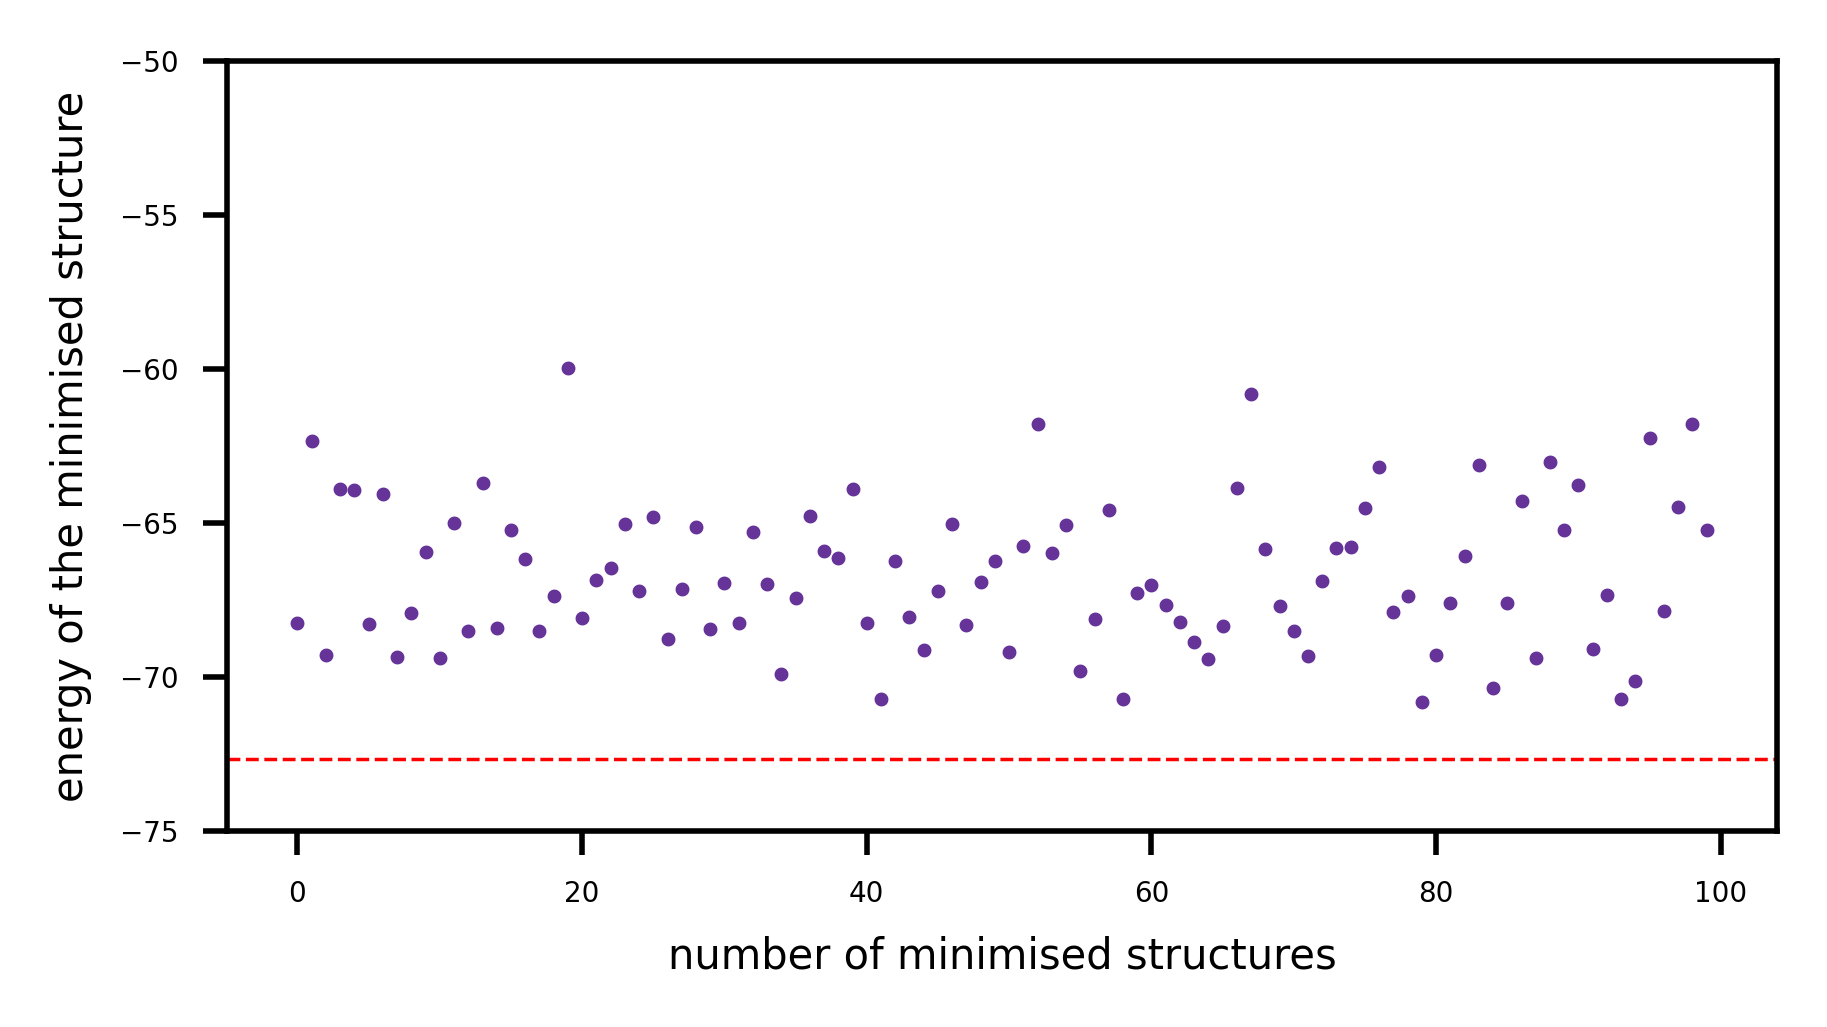

In [17]:
fig=plt.figure(num=None,figsize=(4,2),dpi=500,facecolor='w',edgecolor='k')
plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('number of minimised structures',fontsize=6)
plt.ylabel('energy of the minimised structure',fontsize=6)
plt.scatter(np.arange(len(energies)),energies,color='rebeccapurple',s=1)
plt.ylim(-75, -50)
plt.axhline(y = -72.659782, color = 'r', linestyle = '--', lw=0.5)
plt.savefig('LJ19_min_test.png')

In [ ]:
def enumerate_minima():
    '''
    some function, or indeed collection of functions that can identify the number of different minima we have explored.
    This would require some identification of the uniqueness of each of the simulations, particularly if their energy is very close.
    Extra work I'm not interested in at this moment in particular, maybe closer to the deadline if I have time.

    As a first approximation, I will use the energy values. Not now though
    '''

### Analysis

Here, none of these structures have reached the global minimum, known to be at -72.659782 per atom (the red dashed line). [Some number] of them are below -70. Based on the equivalent energy approximation, we have found [some number of] unique minima.

## Step 5

Implementation of the basin hopping algorithm

In [8]:
def perturb_structure(atoms, method = 'wild', magnitude = 3.0, k = 3):
    '''
    Pertubation Methods
    '''
    def wild(atoms=atoms, magnitude=magnitude):
        '''
        'wild' - randomly selects one atom and moves it in a random direction by a random amount, limited
        by the `magnitude` variable
        '''
        atom_index = np.random.randint(len(atoms) - 1) #selects a random atom from the cluster

        rng = np.random.default_rng()
        direction = rng.normal(size = 3) #randomising the direction the selected atom will be moved
        direction /= np.linalg.norm(direction, keepdims = True) #normalising to produce a unit vector
        length = np.random.uniform(low = 0.0, high = magnitude) #random magnitude between 0 and the specified magnitude
        atoms.positions[atom_index] += direction * length
        
        return atoms
    
    def stretch(atoms=atoms, magnitude = magnitude):
        '''
        'stretch' - calculates the centroid of the cluster, then moves all the atoms away from that centroid
        before performing the energy minimisation. Additional parameter can control how far away all of the
        atoms are moved.
        '''
        centroid = np.mean(atoms.positions, axis = 0)
        vectors = atoms.positions - centroid
        norms = np.linalg.norm(vectors, axis = 1)
        mask = norms > 0.0
        unit_vectors = vectors[mask]/norms[mask, None]

        lengths = np.random.uniform(low = 0.0, high = magnitude, size = (unit_vectors.shape[0], 1))
        atoms.positions += unit_vectors * lengths
        return atoms

    def sweep(atoms=atoms, magnitude=magnitude, k=3):
        '''
        'sweep' - computes cluster centroid, moves the k-furthest atoms in a random directions by a random amount.
        Based on the idea that the core of the cluster is likely stable, but the outermost atoms are those that
        need to be displaced.
        '''

        # Computing distance from centre of the cluster
        centroid = np.mean(atoms.positions, axis = 0)
        vectors = atoms.positions - centroid
        distances = np.linalg.norm(vectors, axis = 1)
        
        #identifying the k-furthest atoms from the centre of the cluster
        idx = np.argsort(distances)[-k:][::-1]

        rng = np.random.default_rng()
        directions = rng.normal(size = (len(idx), 3)) #randomising the directions each of the k-furthest atoms will be moved
        directions /= np.linalg.norm(directions, axis=1, keepdims = True) #normalising to produce the unit vector
        lengths = np.random.uniform(low = 0.0, high = magnitude, size = (directions.shape[0], 1)) #random magnitudes
        
        atoms.positions[idx] += directions * lengths
        return atoms
    
    def swap(atoms):
        '''
        'swap' - swap two random atoms coordinates. e.g. randomly swap the x coordinate of atom a with the x
        coordinate of atom b. OR randomly swap the y coordinate of atom a with the z coordinate of atom b
        '''
        rng = np.random.default_rng()
        n = len(atoms)
        #randomising the atoms selected to be swapped
        atom_a = rng.integers(0, n)
        atom_b = rng.integers(0, n)

        #randomising the x, y, z coordinate to be swapped
        comp_a = rng.integers(0, 3)
        comp_b = rng.integers(0, 3)

        atoms.positions[atom_a, comp_a], atoms.positions[atom_b, comp_b] = atoms.positions[atom_b, comp_b], atoms.positions[atom_a, comp_a]

        return atoms

    if method == 'wild':
        return wild(atoms, magnitude)
        
    elif method == 'stretch':
        return stretch(atoms, magnitude)

    elif method == 'sweep':
        return sweep(atoms, magnitude, k)
    
    elif method == 'swap':
        return swap(atoms)
    


In [ ]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

energies = []
structures = []
minima = []

global_min = float('inf')

for i in range(100):
    if i == 0:
        lj_19 = initialise_structure(n = n, box_length = box_length)
    else:
        lj_19 = perturb_structure(minimum.copy(), method = 'swap')

    minimise_structure(lj_19, id = i)

    energy = lj_19.get_potential_energy()
    energies.append(energy)
    structures.append(lj_19)

    # minimum variable stores the structure with the lowest energy
    if energy < global_min:
        minimum = lj_19.copy()
        global_min = energy
        minima.append(minimum)
    

      Step     Time          Energy          fmax
BFGS:    0 18:14:12 10032982.392863 411045507.412879
BFGS:    1 18:14:12     3746.161771    60104.009079
BFGS:    2 18:14:12      561.669003     5344.091427
BFGS:    3 18:14:12      284.100848     5344.215858
BFGS:    4 18:14:12      281.019142     5340.737227
BFGS:    5 18:14:12      230.578035     3990.005584
BFGS:    6 18:14:12     2386.340637    47891.480296
BFGS:    7 18:14:12      650.383471    11097.721137
BFGS:    8 18:14:12      179.065665     2371.686585
BFGS:    9 18:14:12       34.988332      515.289179
BFGS:   10 18:14:12       18.062443      497.385116
BFGS:   11 18:14:12        5.916047      305.858270
BFGS:   12 18:14:12       -2.679880      122.499646
BFGS:   13 18:14:12       -9.546111       38.368114
BFGS:   14 18:14:12      -10.118742       15.899969
BFGS:   15 18:14:12      -11.692277        5.908746
BFGS:   16 18:14:12      -12.385268        3.370776
BFGS:   17 18:14:12        4.232027      310.002306
BFGS:   18 18

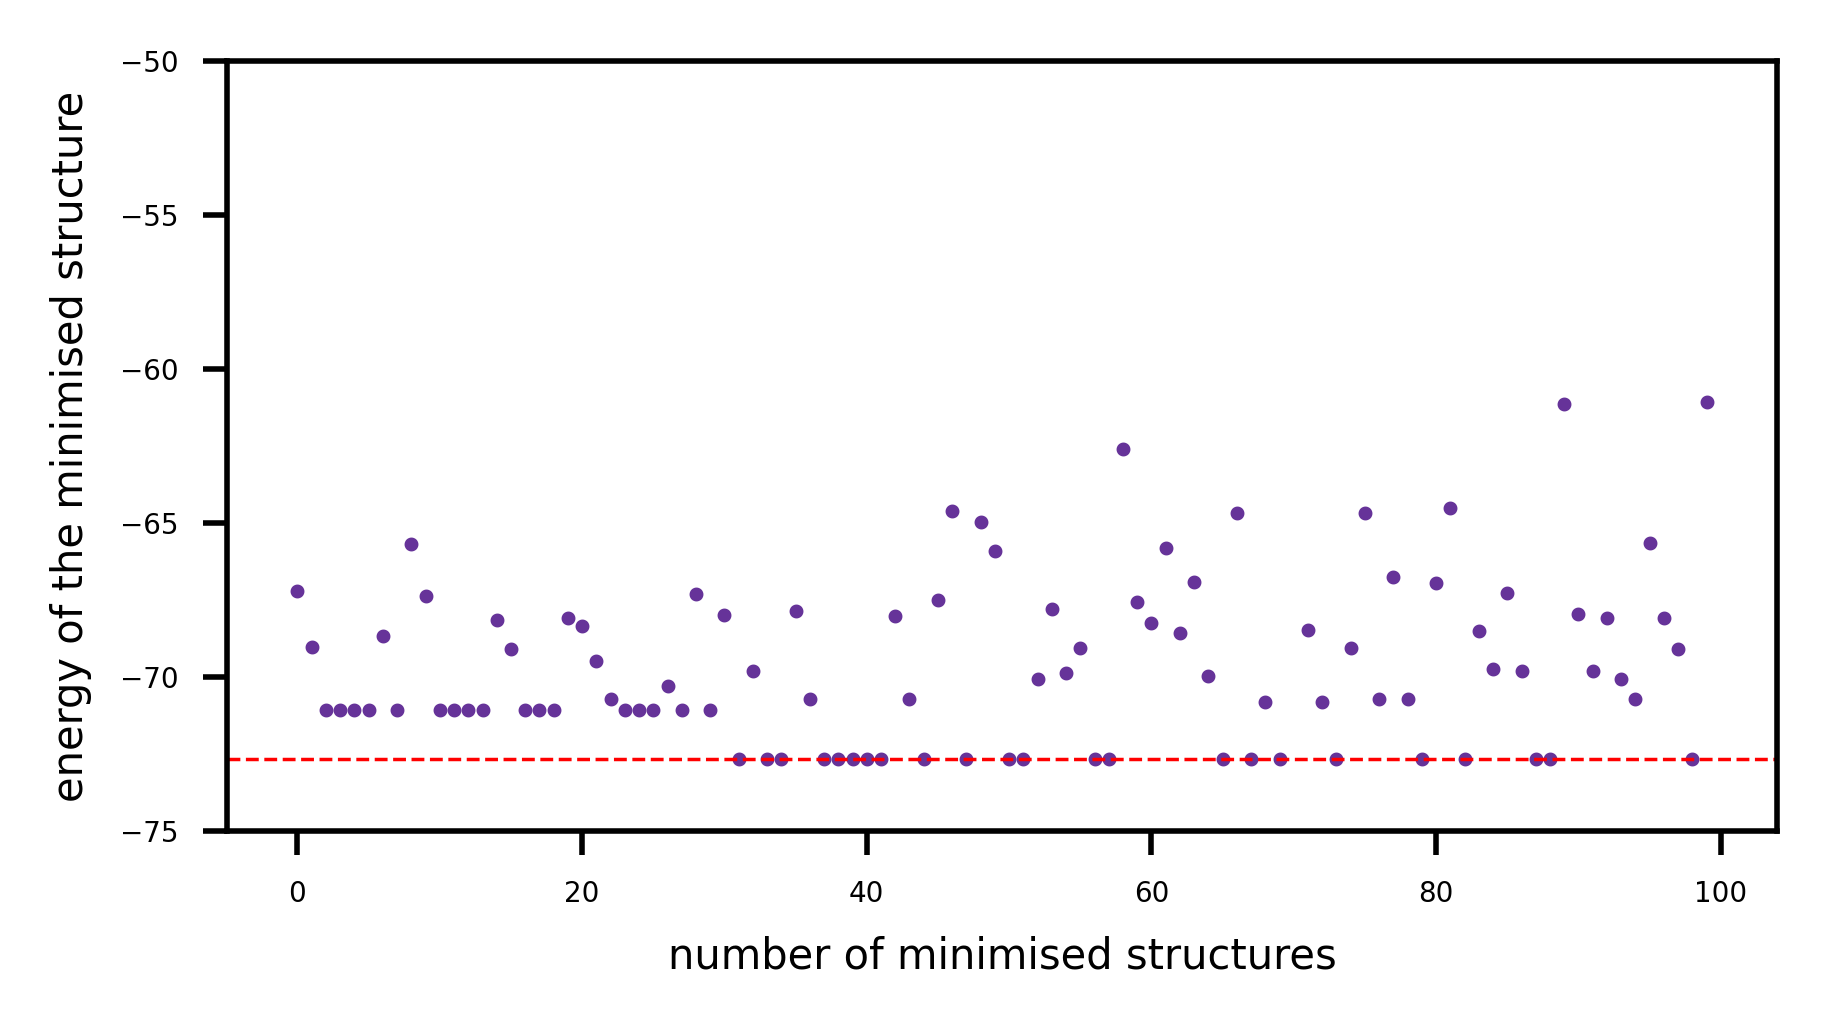

In [10]:
fig=plt.figure(num=None,figsize=(4,2),dpi=500,facecolor='w',edgecolor='k')
plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('number of minimised structures',fontsize=6)
plt.ylabel('energy of the minimised structure',fontsize=6)
plt.ylim(-75, -50)
plt.axhline(y = -72.659782, color = 'r', linestyle = '--', lw=0.5)
plt.scatter(np.arange(len(energies)),energies,color='rebeccapurple',s=1)
plt.savefig('./images/LJ19_min_demo.png')

## Analysis of Pertubation Methods

Varied Magnitude of pertubation up from 1.0 up to 12.0 (to be ridiculous)[1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0]

#### 'Wild'
- pertubation magnitude


#### 'Stretch'
- pertubation magnitude

#### 'Sweep'

Investigate two variables:
- number of atoms to 'sweep' -- from 1 up to 8
- magnitude of pertubation -- from 1.0 up to 12.0 (to be ridiculous)

As magnitude of pertubation increases ...

As the number of atoms perturbed, k, increases, ... 

#### 'Swap'


### Conclusions
The best performing pertubation method was '', with magnitude = ... (and k = ...) . Generally it was seen that as magnitude of pertubtation was increased, ... . For 'Sweep', where the user could select the number of atoms to perturb, it was seen that was the number of atoms to perturb increased ... .

However it is important to take the conclusions from these results with a pinch of salt, as the 'performance' (being measured as the method that finds the global minimum in the fewest number of iterations) is heavily influenced by the very first minimised structure. e.g. if the first structure minimises to -70 kj mol, in this system it seems that it is much more likely to find the global minimum in fewer iterations, compared to an equivalent method but the first configuration minimises to -60 kj mol-1 instead. A proper investigation should 'sample' the performance by running multiple (e.g. 20) iterations of starting from a new random structure.
